In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
fraud = pd.read_csv('./Datasets/Fraud_Data_with_country.csv')

In [9]:
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'])

In [10]:
fraud['time_delta'] = fraud['purchase_time'] - fraud['signup_time']

In [11]:
fraud['time_delta'] = fraud['time_delta'].dt.total_seconds()

In [12]:
fraud['purchase_day'] = fraud.purchase_time.dt.day_name()

In [13]:
fraud['signup_day'] = fraud.signup_time.dt.day_name()

In [14]:
fraud.columns

Index(['Unnamed: 0', 'user_id', 'signup_time', 'purchase_time',
       'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age',
       'ip_address', 'class', 'ip_country', 'time_delta', 'purchase_day',
       'signup_day'],
      dtype='object')

In [15]:
X = fraud[['purchase_value', 'source', 'browser', 'sex', 'age', 'time_delta', 'purchase_day', 'signup_day']] # ip_country
y = fraud['class']

In [16]:
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
  if ('float' in str(t)) or ('int' in str(t)) :
    numeric_features.append(i)
    numeric_indices.append(idx)
  else :
    categorical_features.append(i)
    categorical_indices.append(idx)

  idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['purchase_value', 'age', 'time_delta']  at positions  [0, 4, 5]
Found categorical features  ['source', 'browser', 'sex', 'purchase_day', 'signup_day']  at positions  [1, 2, 3, 6, 7]


In [17]:
from sklearn.model_selection import train_test_split

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
    
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [19]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [18]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

classifiers = [
    AdaBoostClassifier(learning_rate=0.5), 
    GradientBoostingClassifier(),
    LogisticRegression(class_weight={0:0.2,1:0.8}),
    RandomForestClassifier(n_jobs=-1,criterion="gini",class_weight={0:0.2,1:0.8}),
    RandomForestClassifier(n_jobs=-1,criterion="entropy",class_weight={0:0.2,1:0.8}),
    XGBClassifier(n_jobs=-1,learning_rate = 0.5)
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print(classifier)
    y_test_pred = pipe.predict(X_test)
    print("model score: %.8f" % pipe.score(X_test, y_test))
    print('F1 Score on test set : %.8f' % f1_score(y_test, y_test_pred))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=50, random_state=None)
model score: 0.95569599
F1 Score on test set : 0.69011803
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
model score: 0.95566291
F1 Score on test set : 0.68995835
LogisticRegression(C=1.0, class_weight={0: 0.2, 1: 0

In [19]:
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix


stk = StackingClassifier(
    estimators= [
            ('forest', RandomForestClassifier()),
            ('logreg', LogisticRegression(class_weight={0:0.1,1:0.9})),
            ('tree', DecisionTreeClassifier())
    ],
    n_jobs=-1,
    final_estimator=RandomForestClassifier(n_jobs=-1, class_weight={0:0.2,1:0.8})
)

clf_stk = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', stk)])

%time clf_stk.fit(X_train, y_train)

CPU times: user 54.5 s, sys: 929 ms, total: 55.5 s
Wall time: 10min 39s


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['purchase_value', 'age',
                                                   'time_delta']),
                                              

In [20]:
y_train_pred_stk = clf_stk.predict(X_train)
y_test_pred_stk = clf_stk.predict(X_test)

Results for Stacking :
---------------------------------------

Accuracy on training set :  0.9163778342115494
Accuracy on test set :  0.9191013466565199

---------------------------------------

f1-score on train set :  0.547391985672711
f1-score on test set :  0.5587439090416892


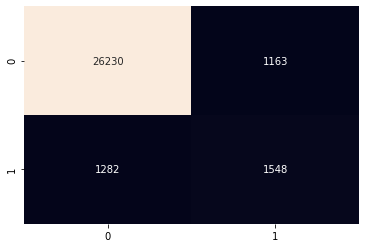

In [21]:
# Print f1_score and accuracy
print('Results for Stacking :\n---------------------------------------\n')

print("Accuracy on training set : ", accuracy_score(y_train, y_train_pred_stk))
print("Accuracy on test set : ", accuracy_score(y_test, y_test_pred_stk))
print('\n---------------------------------------\n')
print("f1-score on train set : ", f1_score(y_train, y_train_pred_stk))
print("f1-score on test set : ", f1_score(y_test, y_test_pred_stk))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_stk)
sns.heatmap(cm, annot=True, fmt="d", cbar=False)

In [35]:
from sklearn.ensemble import VotingClassifier

vote = VotingClassifier(
            estimators = [
                ('ada', AdaBoostClassifier(learning_rate=0.5)),
                ('gdt', GradientBoostingClassifier()),
                ('log', LogisticRegression(class_weight={0:0.2,1:0.8})),
                ('forest_gini', RandomForestClassifier(n_jobs=-1,criterion="gini",class_weight={0:0.2,1:0.8})),
                ('forest_entropy', RandomForestClassifier(n_jobs=-1,criterion="entropy",class_weight={0:0.2,1:0.8})),
                ('xgb', XGBClassifier(n_jobs=-1,learning_rate = 0.5))
            ]
        )

clf_vote = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', vote)])

%time clf_vote.fit(X_train, y_train)

CPU times: user 45.3 s, sys: 570 ms, total: 45.9 s
Wall time: 3min 32s


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['purchase_value', 'age',
                                                   'time_delta']),
                                              

In [36]:
y_train_pred_vote = clf_vote.predict(X_train)
y_test_pred_vote = clf_vote.predict(X_test)

Results for Voting :
---------------------------------------

Accuracy on training set :  0.9570515100629503
Accuracy on test set :  0.9556629057340436

---------------------------------------

f1-score on train set :  0.7024641833810887
f1-score on test set :  0.6899583526145303


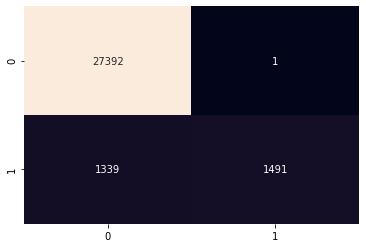

In [38]:
# Print f1_score and accuracy
print('Results for Voting :\n---------------------------------------\n')

print("Accuracy on training set : ", accuracy_score(y_train, y_train_pred_vote))
print("Accuracy on test set : ", accuracy_score(y_test, y_test_pred_vote))
print('\n---------------------------------------\n')
print("f1-score on train set : ", f1_score(y_train, y_train_pred_vote))
print("f1-score on test set : ", f1_score(y_test, y_test_pred_vote))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_vote)
sns.heatmap(cm, annot=True, fmt="d", cbar=False)

In [25]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score

In [26]:
models = []

models.append(('ada', AdaBoostClassifier(learning_rate=0.5)))
models.append(('gdt', GradientBoostingClassifier()))
models.append(('log', LogisticRegression(class_weight={0:0.2,1:0.8})))
models.append(('forest_gini', RandomForestClassifier(n_jobs=-1,criterion="gini",class_weight={0:0.2,1:0.8})))
models.append(('forest_entropy', RandomForestClassifier(n_jobs=-1,criterion="entropy",class_weight={0:0.2,1:0.8})))
models.append(('xgb', XGBClassifier(n_jobs=-1,learning_rate = 0.5)))

ada: 0.956878 (0.001658)
gdt: 0.956828 (0.001700)
log: 0.896798 (0.002860)
forest_gini: 0.956572 (0.001616)
forest_entropy: 0.956547 (0.001697)
xgb: 0.956671 (0.001690)


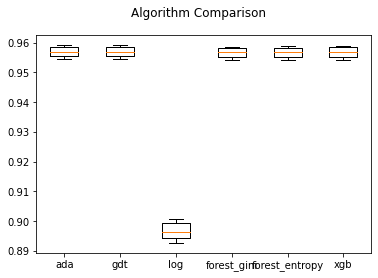

In [27]:
results = []
names = []

for name, classifier in models:
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
    pipe.fit(X_train, y_train)
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
results = []
names = []

for name, classifier in models:
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
    pipe.fit(X_train, y_train)
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()